## Import the necessary dependencies

In [57]:
import pandas as pd
import numpy as np
import json
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import torch

## Load the Yelp review dataset in JSON format

In [58]:
# Function to get the total number of lines in the file
def get_total_lines(filename):
    with open(filename, 'r', encoding='utf-8') as file:
        return sum(1 for _ in file)

# File path
file_path = 'yelp_dataset/yelp_academic_dataset_review.json'

# Get the total number of lines in the file
total_lines = get_total_lines(file_path)

# Randomly select 10,000 line numbers
selected_lines = set(random.sample(range(total_lines), 10000))

# Function to load only the selected lines
def load_selected_data(filename, selected_line_numbers):
    data = []
    with open(filename, 'r', encoding='utf-8') as file:
        for line_number, line in enumerate(file):
            if line_number in selected_line_numbers:
                data.append(json.loads(line))
    return data

# Load the data
yelp_data = pd.DataFrame(load_selected_data(file_path, selected_lines))


In [59]:
# data = []
# with open('yelp_dataset/yelp_academic_dataset_review.json', 'r', encoding='utf-8') as file:
#     for _ in range(10000):  # Load only 10,000 data points
#         line = file.readline()
#         if not line:
#             break
#         data.append(json.loads(line))

# # Convert the JSON data to a DataFrame
# yelp_data = pd.DataFrame(data)

In [60]:
yelp_data.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,LF5UQBZuqjU5B4kTVSIKGg,FsvBdHsES26G0LB2MQZcUg,_agzW_0F9uSJ7i6EJ9ufeg,5.0,1,0,1,"Rebecca didn't Doula my birth. BUT, she was o...",2015-01-04 01:42:59
1,ZNZMWPfPdbbM7dhZlIpoFA,zq2nd0H1dVzi3bta4Zepuw,JvawJ9bSr22xn4R9oLvl_w,4.0,0,0,0,Took a while to get actual service but once we...,2015-05-26 06:01:17
2,RbY47O1d3-J-jQ27xn7fmQ,MPssbJP-whFXwY8hXzTOIg,jLaPtjlLfRSaoBWIcHcSQg,4.0,0,0,0,First time here and I'm not disappointed. Grea...,2018-09-03 01:29:28
3,rNLX7dCFdu6yxYb75UZHFg,g2FlD6WEO7_0cP5_jQzkgg,IYzBKfT_JolGL-MA4STQYA,5.0,0,0,0,"I went here on a Wednesday night and, though i...",2014-11-12 15:01:28
4,tWmm-ByYlKI_RdLYwOYzag,4zPrlEJhra9xpuz-OCRT8g,Wndkw2PinAwTgjeUJOTdCg,5.0,0,0,0,I'm so impressed with this coffee shop. Coming...,2016-12-19 21:42:56


In [61]:
# Check for duplicates
duplicates = yelp_data.duplicated()
print("Total duplicate rows:", duplicates.sum())

# Check for missing values
missing_values = yelp_data.isnull().sum()
print('\n',missing_values)

Total duplicate rows: 0

 review_id      0
user_id        0
business_id    0
stars          0
useful         0
funny          0
cool           0
text           0
date           0
dtype: int64


## Selecting the features

In [62]:
# Select the necessary features
yelp_data = yelp_data[['text', 'stars']]

# Map star ratings to sentiment labels (e.g., 0 for 1-2 stars, 1 for 3 stars, 2 for 4-5 stars)
yelp_data['sentiment'] = yelp_data['stars'].apply(lambda x: 0 if x <= 2 else (1 if x == 3 else 2))

## Splitting the dataset

In [63]:
# Split data into train, validation, and test sets
train_data, test_data = train_test_split(yelp_data, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(test_data, test_size=0.5, random_state=42)

## Load the pre-trained BERT model

In [64]:
# Load pre-trained BERT tokenizer and model in TensorFlow
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Tokenize and preprocess the data

In [65]:
def tokenize_data(data):
    input_ids = []
    attention_masks = []
    labels = []

    for index, row in data.iterrows():
        review = row['text']
        label = row['sentiment']

        encoded_data = tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=128,  # You can adjust the maximum sequence length
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        input_ids.append(encoded_data['input_ids'])
        attention_masks.append(encoded_data['attention_mask'])
        labels.append(label)

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)

    return input_ids, attention_masks, labels

train_input_ids, train_attention_masks, train_labels = tokenize_data(train_data)
val_input_ids, val_attention_masks, val_labels = tokenize_data(val_data)
test_input_ids, test_attention_masks, test_labels = tokenize_data(test_data)

## Define dataloaders

In [66]:
batch_size = 32

train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)

val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels)
val_sampler = SequentialSampler(val_dataset)
val_dataloader = DataLoader(val_dataset, sampler=val_sampler, batch_size=batch_size)

test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=batch_size)

In [67]:
# Check if a GPU is available; if not, use the CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define optimizer and loss function
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

# # Move the model to the appropriate device
# model.to(device)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## Training loop

In [68]:
# num_epochs = 3

# for epoch in range(num_epochs):
#     model.train()
#     total_loss = 0

#     for batch in tqdm(train_dataloader, desc=f'Epoch {epoch + 1}'):
#         batch = tuple(t.to(device) for t in batch)
#         input_ids, attention_mask, labels = batch

#         optimizer.zero_grad()

#         outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#         loss = outputs.loss
#         total_loss += loss.item()

#         loss.backward()
#         optimizer.step()

#     average_loss = total_loss / len(train_dataloader)
#     print(f'Average Loss: {average_loss:.4f}')

## Saving the model

In [69]:
# torch.save(model, 'bert_model.pth')

## Loading the saved model

In [70]:
model = torch.load('bert_model.pth')
model.to(device) 

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

## Evaluation

### Classification report

In [71]:
model.eval()
predictions = []
true_labels = []

for batch in tqdm(val_dataloader, desc='Validation'):
    batch = tuple(t.to(device) for t in batch)
    input_ids, attention_mask, labels = batch

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)

    logits = outputs.logits
    predicted_labels = torch.argmax(logits, dim=1).tolist()
    predictions.extend(predicted_labels)
    true_labels.extend(labels.tolist())

accuracy = accuracy_score(true_labels, predictions)
report = classification_report(true_labels, predictions)

print(f'Validation Accuracy: {accuracy:.4f}')
print(report)

Validation: 100%|██████████| 32/32 [01:06<00:00,  2.08s/it]

Validation Accuracy: 0.8570
              precision    recall  f1-score   support

           0       0.87      0.82      0.84       237
           1       0.42      0.59      0.49       100
           2       0.95      0.91      0.93       663

    accuracy                           0.86      1000
   macro avg       0.75      0.77      0.75      1000
weighted avg       0.88      0.86      0.87      1000



### Confusion matrix

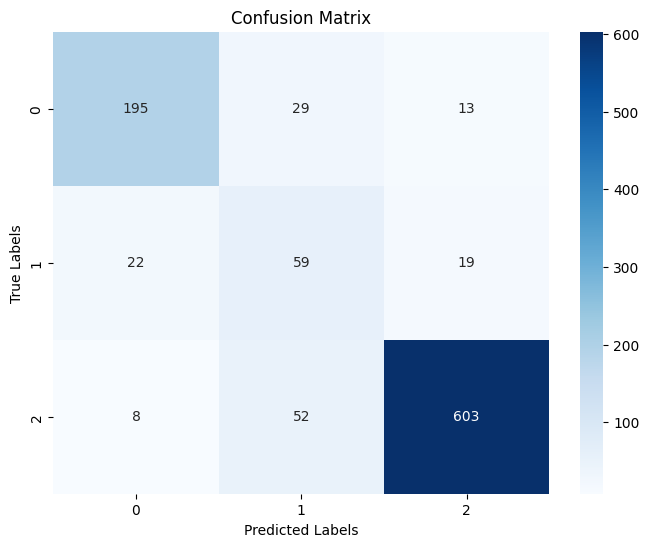

In [72]:
# Create a confusion matrix
confusion_mat = confusion_matrix(true_labels, predictions)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### Bar chart

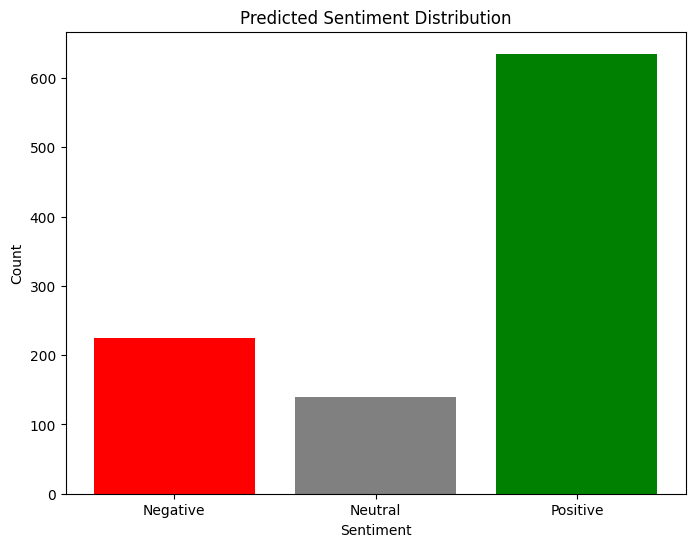

In [73]:
# Count the predicted sentiment labels
predicted_counts = [predictions.count(0), predictions.count(1), predictions.count(2)]

# Define sentiment labels
sentiment_labels = ['Negative', 'Neutral', 'Positive']

# Create a bar chart
plt.figure(figsize=(8, 6))
plt.bar(sentiment_labels, predicted_counts, color=['red', 'gray', 'green'])
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Predicted Sentiment Distribution')
plt.show()


## Test Case

In [74]:
def analyze_sentiment(comment):
    # Tokenize and preprocess the comment
    inputs = tokenizer.encode_plus(
        comment,
        add_special_tokens=True,
        max_length=128,  # can adjust the maximum sequence length
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt',
        truncation=True
    )

    # Perform inference
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)

    logits = outputs.logits
    predicted_label = torch.argmax(logits, dim=1).item()

    # Define sentiment labels
    sentiment_labels = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
    
    # Get the sentiment label and score
    sentiment_label = sentiment_labels[predicted_label]
    sentiment_score = torch.softmax(logits, dim=1)[0][predicted_label].item()

    return sentiment_label, sentiment_score


In [75]:
comment = "i mean it is okay i guess"
sentiment_label, sentiment_score = analyze_sentiment(comment)

print(f"Sentiment: {sentiment_label}")
print(f"Sentiment Score: {sentiment_score:.4f}")

Sentiment: Neutral
Sentiment Score: 0.6811
